# Milstone project 1: Food Vision Big

See the annotated version of this notebook on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb

## Check GPU

* Google Colab offers free GPUs (thank you Google), however, not all of them are compatible with mixed precision training.

Google colab offers:
* K8 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

knowing this, in oder to use mixed precision training we need access to a Tesla T4 (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+ (see here:https://developer.nvidia.com/cuda-gpus)

## Get helper functions

In past modules, we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

The script we've got available can be found on GitHub: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-15 23:01:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-15 23:01:53 (102 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

If you want to get an overview of TensorFlow Datasets (TFDS), read the guide: https://www.tensorflow.org/datasets/overview

In [7]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [ ]:
# List all available datasets
datasets_list = tfds.list_builders()  # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets?

True


In [ ]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, #data gets returned in tuple format (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [ ]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [22]:
# get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [19]:
# Take one sample of the train data
train_one_sample = train_data.take(1)   # samples are in format (image_tensor, label)

In [20]:
# What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [23]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 41
  Class name (str form): french_onion_soup
  


In [24]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[168, 148, 123],
        [192, 172, 147],
        [200, 180, 155],
        ...,
        [179, 165, 139],
        [188, 172, 147],
        [154, 138, 113]],

       [[184, 164, 139],
        [209, 189, 164],
        [212, 192, 167],
        ...,
        [207, 193, 167],
        [218, 202, 177],
        [184, 168, 143]],

       [[186, 166, 139],
        [214, 194, 167],
        [211, 194, 168],
        ...,
        [207, 193, 167],
        [217, 203, 177],
        [180, 166, 140]],

       ...,

       [[206, 198, 179],
        [236, 228, 209],
        [230, 221, 204],
        ...,
        [226, 214, 200],
        [239, 227, 211],
        [203, 191, 175]],

       [[216, 208, 187],
        [239, 231, 210],
        [233, 225, 206],
        ...,
        [227, 215, 201],
        [237, 225, 209],
        [205, 193, 177]],

       [[173, 165, 144],
        [198, 190, 169],
        [204, 196, 177],
        ...,
        [197, 185, 17

In [ ]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Dataset


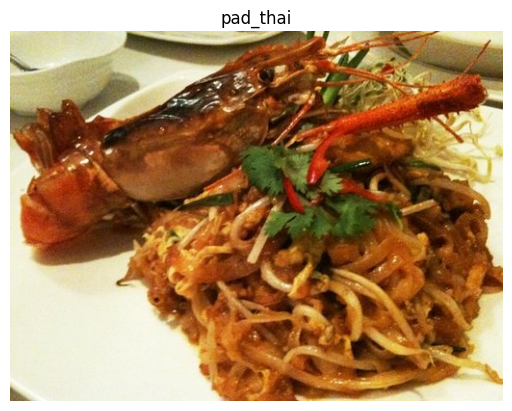

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])   # Add title to image to verify the label is associated with the right image
plt.axis(False);

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain way (e.g. batched, normilized, etc).

However, not all data (including data from TensorFlow Datasets) comes like this.

so in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `unit8` datatype
* Comprised of all different size tensor (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better

With these point in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data (these architectures have rescaling built-in).

This means our functions needs to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from `unit8` to `float32`

In [16]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'unit8' -> 'float32' and reshapes image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape])    # reshape target image
  # image = image/255.  # scale image values (not required with EfficientNetBX models from tf.keras.applications)
  return tf.cast(image, tf.float32), label  # return (float32_image, label) tuple

In [25]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}..., \nShape:{preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[168 148 123]
  [192 172 147]
  [200 180 155]
  ...
  [179 165 139]
  [188 172 147]
  [154 138 113]]

 [[184 164 139]
  [209 189 164]
  [212 192 167]
  ...
  [207 193 167]
  [218 202 177]
  [184 168 143]]]..., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[194.12755 174.12755 149.12755]
  [204.66325 184.66325 159.66325]
  [198.20918 180.42348 158.85204]
  ...
  [200.12253 186.55106 160.97958]
  [204.22949 190.22949 164.22949]
  [195.14168 179.14168 154.14168]]

 [[197.10204 177.10204 150.10204]
  [202.5102  185.5102  159.5102 ]
  [209.96428 193.83673 169.47958]
  ...
  [201.301   187.72952 162.15805]
  [207.8622  193.8622  167.8622 ]
  [197.218   183.218   157.218  ]]]..., 
Shape:(224, 224, 3), 
Datatype: <dtype: 'float32'>


## Batch & prepare datasets

We're now going to make our data input pipeline run really fast.

For more resources on this, I'd highly going through the following guide: https://www.tensorflow.org/guide/data_performance


In [26]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> "Hey, TensorFlow, map this preprocessing function (`preprocess_img`) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch."

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results (so we can visulize them later if need be)
* ModelCheckpoint callback to save our model's progress after feature extraction.

In [ ]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) # don't print whether or not model is being saved

## Setup mixed precision training

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision: https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")  # set global data policy to mixed precision

In [ ]:
!nvidia-smi

Sun Oct 15 23:12:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W /  70W |    361MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model doesn't you can have a layer like below
# X = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False)    # make sure layers which should be inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
label

<tf.Tensor: shape=(), dtype=int64, numpy=70>

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

## Checking layer dtype policies (are we using mixed precision?)


In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name`: the human readable name of a particular layer
* `layer.trainable`: is the layer trainable or not? (if `False`, the weights are frozen)
* `layer.dtype`: the datatype a layer stores its varibales in
* `layer.dtype_policy`: the data type policy a layer computes on its variables with

In [ ]:
# Check the dtype policy attributes of layers attributes of layer in the base model
for layer in model.layers[1].layers: # check the layers of the base model (layer at index 1 of `model`)
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [ ]:
# mixed_precision.set_global_policy("float32")

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of frozen layers

In [ ]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20231015-231248
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7195 - accuracy: 0.5810

2368/2368 [==============================] - 213s 80ms/step - loss: 1.7195 - accuracy: 0.5810 - val_loss: 1.1381 - val_accuracy: 0.6923
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1997 - accuracy: 0.6883

2368/2368 [==============================] - 192s 79ms/step - loss: 1.1997 - accuracy: 0.6883 - val_loss: 1.0289 - val_accuracy: 0.7158
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.0535 - accuracy: 0.7243

2368/2368 [==============================] - 192s 79ms/step - loss: 1.0535 - accuracy: 0.7243 - val_loss: 0.9862 - val_accuracy: 0.7259


In [ ]:
# evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 57s 73ms/step - loss: 0.9949 - accuracy: 0.7304


[0.9949074387550354, 0.7303762435913086]

## Off to you..

We've covered a lot of ground so far, but since this is a milestone project, it's time for you to takeover.

More specifically, you're challenge is to complete the TEMPLATE version of 07 to obtain a computer vision model (building off the one we've built in this notebook) to beat the DeepFood paper.

In other words, you're going to create Food Vision Big!!

You can find the TEMPLATE notebook here.


##TODO: Save the whole model to file

In [ ]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
model.save("drive/MyDrive/101_food_classes_100_percent_saved_big_dog_model")

In [3]:
import tensorflow as tf

In [4]:
# Load an evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/101_food_classes_100_percent_saved_big_dog_model")

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
base_model.layers

In [ ]:
for layer in base_model.layers: # check the layers of the base model (layer at index 1 of `model`)
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

In [27]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
loaded_results = loaded_model.evaluate(test_data)

790/790 [==============================] - 64s 68ms/step - loss: 0.9949 - accuracy: 0.7304


In [ ]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables
import numpy as np
np.isclose(results_feature_extract_model, loaded_results)

array([ True,  True])

## TODO: Preparing our model's layers for fine-tuning
Next: Fine-tune the feature extraction model to beat the DeepFood paper.

Like all good cooking shows, I've saved a model I prepared earlier (the feature extraction model from above) to Google Storage.

You can download it to make sure you're using the same model as originall trained going forward.

In [10]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip

--2023-10-17 00:29:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.207, 74.125.132.207, 74.125.201.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  --.-KB/s    in 0.1s    

2023-10-17 00:29:32 (142 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [11]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [12]:
# Load and evaluate downloaded GS model
downloaded_gs_model = tf.keras.models.load_model("downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
# Get a summary of the downloaded model
downloaded_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [28]:
# How does the loaded model perform? (evaluate it on the test dataset)
perform_downloaded_gs_model = downloaded_gs_model.evaluate(test_data)
perform_downloaded_gs_model

790/790 [==============================] - 53s 64ms/step - loss: 1.0881 - accuracy: 0.7066


[1.0880993604660034, 0.7066138386726379]

In [ ]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)
for layer in downloaded_gs_model.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 False
pooling_layer True
dense True
softmax_float32 True


In [29]:
# Unfreeze all of the layer in the base model
downloaded_gs_model.trainable = True

In [ ]:
for layer in downloaded_gs_model.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 True
pooling_layer True
dense True
softmax_float32 True


In [ ]:
# Check to see what dtype_policy of the layers in your loaded model are
for layer in downloaded_gs_model.layers: # check the layers of the base model (layer at index 1 of `model`)
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
# Monitor the val_loss and stop training if it doesn't improve for 3 epochs
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping for more
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3)


# Create ModelCheckpoint callback to save best model during fine-tuning
# Save the best model only
# Monitor val_loss while training and save the best model (lowest val_loss)
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint for more
checkpoint_filepath = "model_checkpoints2/cp.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               monitor='val_loss',
                                                               save_best_only=True)

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [ ]:
# Compile the model ready for fine-tuning
# Use the Adam optimizer with a 10x lower than default learning rate
downloaded_gs_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # learning rate lower by 10x
              metrics=["accuracy"])

In [ ]:
# Start to fine-tune (all layers)
# Use 100 epochs as the default
# Validate on 15% of the test_data
# Use the create_tensorboard_callback, ModelCheckpoint and EarlyStopping callbacks you created eaelier
# YOUR_CODE_HERE
history_101_food_classes_feature_extract = downloaded_gs_model.fit(train_data,
                                                     epochs=100, # fine-tune for a maximum of 100 epochs
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint_callback,
                                                                early_stopping,
                                                                reduce_lr])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20231015-232656
Epoch 1/100
2368/2368 [==============================] - 480s 177ms/step - loss: 0.9240 - accuracy: 0.7513 - val_loss: 0.8402 - val_accuracy: 0.7728 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 416s 174ms/step - loss: 0.5783 - accuracy: 0.8402 - val_loss: 0.7642 - val_accuracy: 0.7942 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 381s 159ms/step - loss: 0.3284 - accuracy: 0.9069 - val_loss: 0.8714 - val_accuracy: 0.7887 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1720 - accuracy: 0.9491
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 383s 160ms/step - loss: 0.1720 - accuracy: 0.9491 - val_loss: 0.9861 - val_accuracy: 0.7855 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 

In [ ]:
# Save model locally
downloaded_gs_model.save("drive/MyDrive/101_food_classes_100_percent_saved_big_dog_model_downloaded")

In [ ]:
# Evaluate mixed precision trained fine-tuned model (this should beat DeepFood's 77.4% top-1 accuracy)
results_fine_tuned_gs_model = downloaded_gs_model.evaluate(test_data)
results_fine_tuned_gs_model

790/790 [==============================] - 62s 78ms/step - loss: 1.0471 - accuracy: 0.7984


[1.0471020936965942, 0.7984158396720886]

##Evaluate your trained model
Some ideas you might want to go through:

1. Find the precision, recall and f1 scores for each class (all 101).
Build a confusion matrix for each of the classes.
2. Find your model's most wrong predictions (those with the highest prediction probability but the wrong prediction).
3. See the evaluation section at the end of Transfer Learning Part 3: Scaling Up for more.

In [75]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [76]:
# Make predictions with model
preds_probs = downloaded_gs_model.predict(test_data, verbose=1)  # set verbosity to see how long is left

790/790 [==============================] - 57s 71ms/step


In [77]:
# How many predictions are there?
len(preds_probs)

25250

In [78]:
# What's the shape of our predictions
preds_probs.shape

(25250, 101)

In [79]:
preds_probs[:10]

array([[9.4572315e-04, 1.4946676e-05, 4.1343606e-06, ..., 2.1333022e-03,
        4.5956031e-04, 1.7382722e-01],
       [1.4478357e-04, 3.6180536e-05, 2.2424516e-04, ..., 1.5114034e-04,
        1.3050159e-03, 8.4122257e-05],
       [1.2022526e-05, 4.4832985e-05, 3.7286001e-05, ..., 1.5571183e-06,
        1.0207400e-04, 4.1997469e-06],
       ...,
       [3.2918492e-06, 5.9998648e-08, 1.1381883e-06, ..., 1.7964840e-07,
        1.3311281e-07, 1.2537230e-06],
       [6.1709402e-09, 1.8899608e-07, 1.9047839e-07, ..., 1.2665729e-06,
        2.6769022e-04, 8.0025977e-08],
       [2.3569359e-02, 1.9231005e-04, 8.4520376e-04, ..., 3.4087778e-03,
        4.8543215e-03, 2.0986636e-01]], dtype=float32)

In [80]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([9.45723150e-04, 1.49466759e-05, 4.13436055e-06, 1.78888295e-05,
        1.29119566e-04, 2.36099790e-04, 1.45129718e-06, 3.32904383e-05,
        2.37326287e-02, 4.54206282e-04, 3.98493867e-04, 4.53117082e-07,
        1.19901367e-03, 1.98651548e-03, 2.21395493e-03, 1.23688980e-04,
        7.18961097e-03, 7.71897798e-03, 1.71983842e-07, 3.43471911e-05,
        1.81651131e-07, 6.70554535e-03, 6.32624794e-03, 2.14551867e-04,
        2.02706997e-05, 6.45364571e-06, 1.00952006e-04, 1.53206498e-03,
        7.77055320e-05, 3.09880525e-01, 1.73292831e-02, 6.93935901e-04,
        5.19656351e-05, 4.81327582e-08, 1.41416374e-03, 4.05439459e-06,
        4.70184209e-03, 1.08925897e-05, 4.19064747e-07, 8.31907801e-06,
        3.32205218e-06, 8.35163792e-06, 1.15308026e-03, 9.51783818e-07,
        1.48259332e-07, 1.81105092e-01, 1.77816628e-06, 1.06787191e-07,
        2.85862661e-05, 5.84265363e-05, 4.94818187e-06, 9.66772291e-07,
        7.74025903e-05, 1.90454011e-04, 2.01069483e-07, 5.707308

In [81]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([29, 81, 91, 53, 97, 97, 10, 31,  3, 94])

In [62]:
first_element = test_data.take(1)
image, label = list(first_element)[0]
label.numpy()

29

In [50]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=False,
                                             as_supervised=True, #data gets returned in tuple format (data, label)
                                             with_info=True)

In [63]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data:
  y_labels.append(labels.numpy())    # currently test labels look like: [0, 0, 0, 1, ... 0, 0] we want the index value where the "1" occurs
y_labels[500] # look at the first 10

64

In [69]:
y_labels[25000]

43

In [68]:
len(y_labels)

25250

In [ ]:
len(pred_classes)/101

250.0

In [ ]:
# Get a list of class names
class_names = ds_info.features["label"].names
class_names[52]


'gyoza'

In [70]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x_labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)
  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [71]:
y_labels[542]

88

In [82]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True)

### A graph showing the f1-scores of each class.

scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called classification_report let's try it out

In [83]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.65      0.32      0.43       250
           1       0.69      0.72      0.70       250
           2       0.73      0.76      0.74       250
           3       0.78      0.70      0.74       250
           4       0.61      0.54      0.57       250
           5       0.52      0.66      0.58       250
           6       0.77      0.85      0.81       250
           7       0.77      0.89      0.83       250
           8       0.55      0.43      0.49       250
           9       0.79      0.51      0.62       250
          10       0.67      0.56      0.61       250
          11       0.75      0.72      0.74       250
          12       0.71      0.72      0.71       250
          13       0.61      0.72      0.66       250
          14       0.69      0.70      0.69       250
          15       0.60      0.44      0.51       250
          16       0.64      0.48      0.55       250
          17       0.68    

In [84]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.6504065040650406,
  'recall': 0.32,
  'f1-score': 0.42895442359249325,
  'support': 250},
 '1': {'precision': 0.6856060606060606,
  'recall': 0.724,
  'f1-score': 0.7042801556420233,
  'support': 250},
 '2': {'precision': 0.7325581395348837,
  'recall': 0.756,
  'f1-score': 0.7440944881889763,
  'support': 250},
 '3': {'precision': 0.7777777777777778,
  'recall': 0.7,
  'f1-score': 0.7368421052631577,
  'support': 250},
 '4': {'precision': 0.6081081081081081,
  'recall': 0.54,
  'f1-score': 0.5720338983050848,
  'support': 250},
 '5': {'precision': 0.5188679245283019,
  'recall': 0.66,
  'f1-score': 0.5809859154929579,
  'support': 250},
 '6': {'precision': 0.7661870503597122,
  'recall': 0.852,
  'f1-score': 0.8068181818181818,
  'support': 250},
 '7': {'precision': 0.7689655172413793,
  'recall': 0.892,
  'f1-score': 0.8259259259259258,
  'support': 250},
 '8': {'precision': 0.5538461538461539,
  'recall': 0.432,
  'f1-score': 0.48539325842696635,
  'support': 2

Let's plot all of our classes F1-scores...

In [85]:
class_names[98]

'tiramisu'

In [86]:
classification_report_dict["99"]["f1-score"]

0.5368620037807182

In [87]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy":  # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

class_f1_scores

{'apple_pie': 0.42895442359249325,
 'baby_back_ribs': 0.7042801556420233,
 'baklava': 0.7440944881889763,
 'beef_carpaccio': 0.7368421052631577,
 'beef_tartare': 0.5720338983050848,
 'beet_salad': 0.5809859154929579,
 'beignets': 0.8068181818181818,
 'bibimbap': 0.8259259259259258,
 'bread_pudding': 0.48539325842696635,
 'breakfast_burrito': 0.6195121951219512,
 'bruschetta': 0.6100217864923748,
 'caesar_salad': 0.7357723577235773,
 'cannoli': 0.714570858283433,
 'caprese_salad': 0.6617647058823529,
 'carrot_cake': 0.693069306930693,
 'ceviche': 0.5058004640371229,
 'cheesecake': 0.55125284738041,
 'cheese_plate': 0.7134724857685009,
 'chicken_curry': 0.6160337552742615,
 'chicken_quesadilla': 0.679245283018868,
 'chicken_wings': 0.8232931726907632,
 'chocolate_cake': 0.6340425531914893,
 'chocolate_mousse': 0.4675324675324675,
 'churros': 0.8240534521158128,
 'clam_chowder': 0.7586206896551725,
 'club_sandwich': 0.7817047817047817,
 'crab_cakes': 0.5454545454545455,
 'creme_brulee': 0

In [88]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores[:10]

class_names  f1-score
33            edamame  0.977867
63           macarons  0.915663
64          miso_soup  0.891616
69            oysters  0.887129
54  hot_and_sour_soup  0.884086
45      frozen_yogurt  0.867076
65            mussels  0.865979
76              pizza  0.864646
75                pho  0.862069
88      seaweed_salad  0.861472

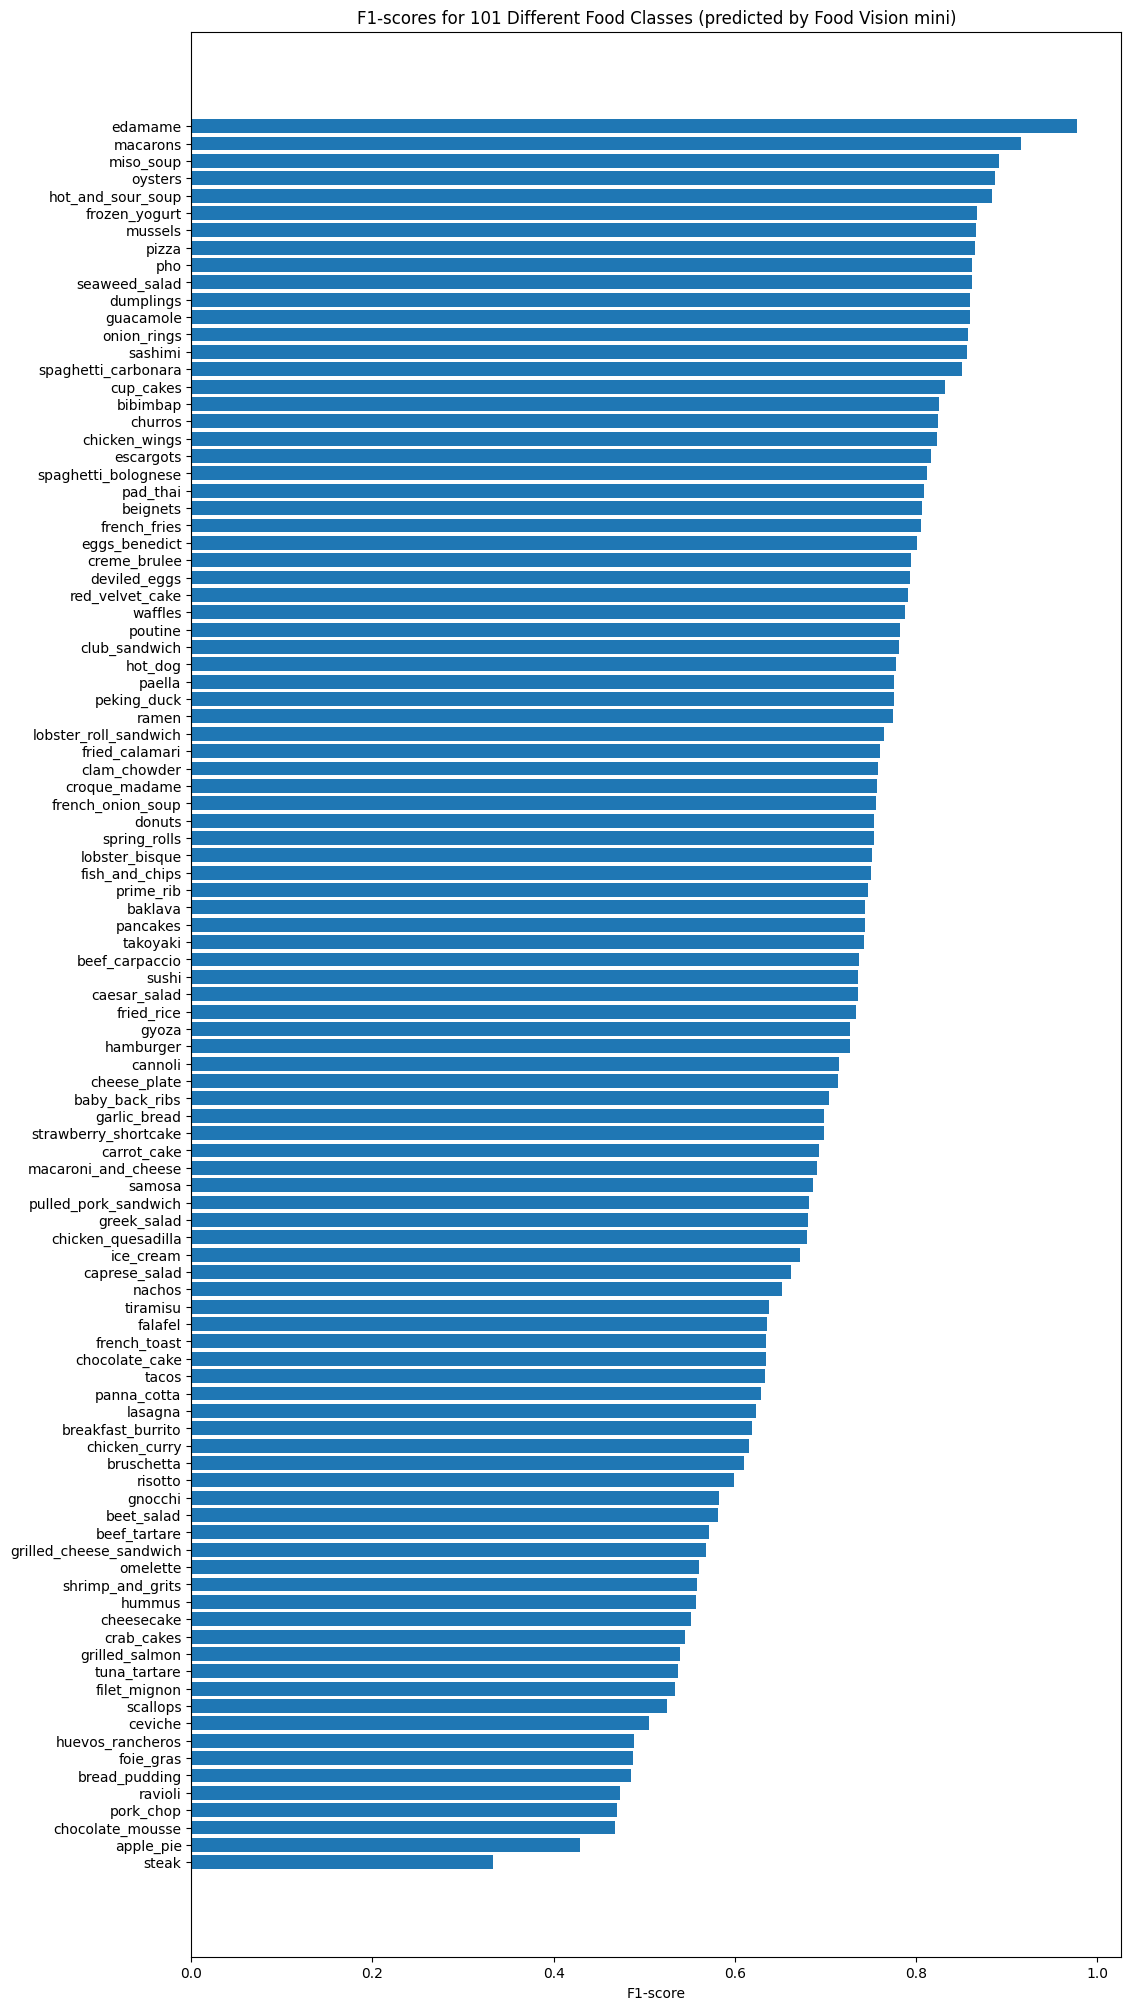

In [89]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)    # getf1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision mini)")
ax.invert_yaxis(); #Reverse the order of our plot

# Challenge: add values to the end of each bar of what the actual f1-score is
# hint: use the "autolabel" function from here: https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html

##Visualizing predictions on test images
Now, this is the real test, how does our model go on food images not even in our test dataset (images of our own, we'll see this later on).

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:

Read in a target image filepath using tf.io.read_file()
Turn the image into a Tensor using tf.io.decode_image()
Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [90]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/no
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img  # don't need to rescale images for EfficientNet models in TensorFlow

In [92]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-10-17 00:55:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.120.207, 74.125.126.207, 142.250.152.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.120.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  31.4MB/s    in 26s     

2023-10-17 00:56:07 (58.8 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [93]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-17 00:56:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-17 00:56:24 (76.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [94]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, walk_through_dir, unzip_data

In [95]:
unzip_data("101_food_classes_10_percent.zip")
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

101_food_classes_10_percent/test/beet_salad/555493.jpg
1/1 [==============================] - 0s 56ms/step
101_food_classes_10_percent/test/hamburger/2103408.jpg
1/1 [==============================] - 0s 49ms/step
101_food_classes_10_percent/test/sushi/101625.jpg
1/1 [==============================] - 0s 69ms/step


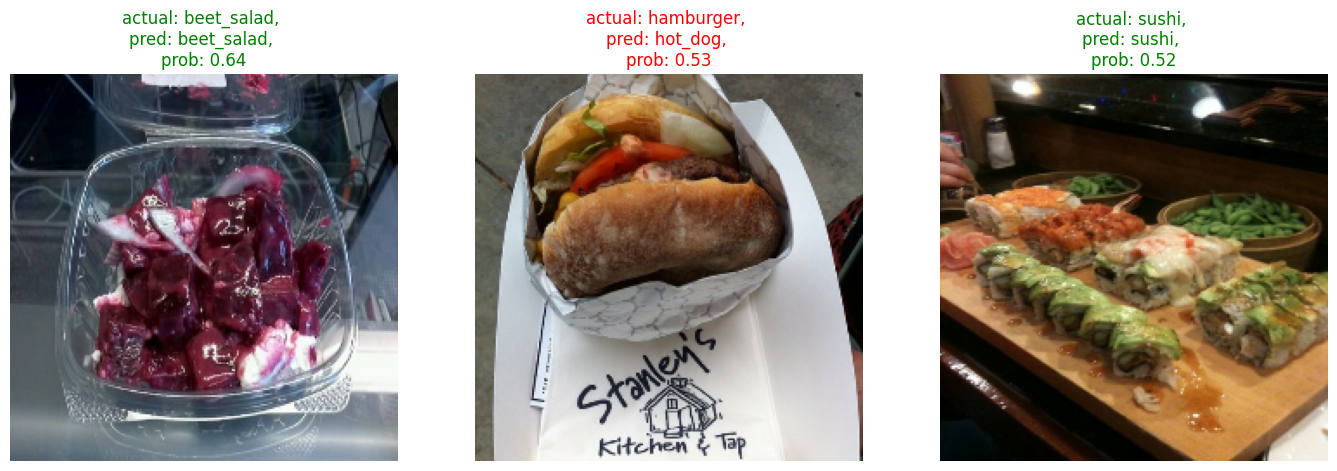

In [98]:
# Make preds on a series of random images
import os
import random
plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image(s) from random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename
  print(filepath)

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)
  pred_prob = downloaded_gs_model.predict(img_expanded)      # get predictions probabilities array
  pred_class = class_names[pred_prob.argmax()]  # get highest prediction probability index and match it class_names list
  # print(pred_prob)
  # print(pred_class)

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, \npred: {pred_class}, \nprob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);